In [1]:
%matplotlib inline
#인풋아웃풋은 numpy
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from collections import Counter
import pandas as pd
from tensorflow.keras.callbacks import Callback
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers


#### data load
- (train data) X_train : 60000, 28x28
- (train data) Y_train : 60000, str
- (test data) X_test : 10000, 28x28
- (test data) Y_test : 10000, str


In [2]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_test

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

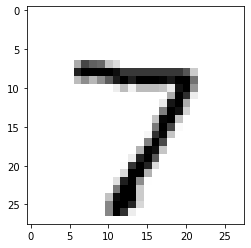

In [3]:
plt.imshow(X_test[0], cmap='binary')

### convert and ready to data
* input image reshape
* output Y one hot encoding

In [4]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train/255.0
X_test = X_test/255.0

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### VGG19 Model 기반 모델 구조 생성
* 입력 사이즈 28X28
* Convolution block : 5
*  fullconntected NN layer(FC) : 3
*  FC1 Dropout ration : 20%
*  FC의 output은 regularization으로 출력 평탄화후 다음 activation에 전달
*  stride mask size : 2x2
*  kernel  size : 3x3
*  출력 경계선 padding : same
*  activation function : relu
*  optimizer : adam
*  출력 클래스 : 10
*  GPU : 2 CUDA SLI 4epochs, batch_size 500기준 43sec
*  CPU : 2700x 4epochs, batch_size 100 기준 4시간 12분

In [5]:
#TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels.h5'
#weights_path = get_file('vgg19_weights_th_dim_ordering_th_kernels.h5',TH_WEIGHTS_PATH,cache_subdir='models')
#from keras.utils.data_utils import get_file
model = Sequential()
# Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',  activation='relu', input_shape=(28,28,1,), name='block1_conv1'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',  activation='relu',  name='block1_conv2'))
model.add(MaxPool2D(pool_size=(2,2), strides=1, name='block1_pool'))

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same',  activation='relu',  name='block2_conv1'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same',  activation='relu',  name='block2_conv2'))
model.add(MaxPool2D(pool_size=(2,2), strides=2,name='block2_pool'))

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same',  activation='relu',  name='block3_conv1'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same',  activation='relu',  name='block3_conv2'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same',  activation='relu',  name='block3_conv3'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same',  activation='relu',  name='block3_conv4'))
model.add(MaxPool2D(pool_size=(2,2), strides=2,name='block3_pool'))

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block4_conv1'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block4_conv2'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block4_conv3'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block4_conv4'))
model.add(MaxPool2D(pool_size=(2,2), strides=2,name='block4_pool'))

# Block 5
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block5_conv1'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block5_conv2'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block5_conv3'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',  activation='relu',  name='block5_conv4'))
model.add(MaxPool2D(pool_size=(2,2), strides=2,name='block5_pool'))


model.add(Flatten())
model.add(Dense(1024, activation='relu', name='fc1'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', name='fc2'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax', name='predictions')) #최종은 항상 클래스 종류의 개수 

          
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 27, 27, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 27, 27, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 27, 27, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 13, 13, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 13, 13, 256)       2

#### Error function 
* loss function : categorical crossentropy
* optimizer : Adam
* learning rate : 0.00001 ~ 0.004

In [6]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr = 0.00001), metrics=['accuracy'])

#### taining
* batch size : 50 
* epochs : 2~10
* validation test set 크기 : train data의 20% => 12000 

In [7]:
hist = model.fit(X_train, Y_train, batch_size=200, epochs=4, validation_split=0.2)

Epoch 1/4
240/240 [==============================] - 2337s 10s/step - loss: 0.4980 - accuracy: 0.8572 - val_loss: 2.1567 - val_accuracy: 0.6204
Epoch 2/4
240/240 [==============================] - 2354s 10s/step - loss: 0.0905 - accuracy: 0.9744 - val_loss: 1.0010 - val_accuracy: 0.9686
Epoch 3/4
240/240 [==============================] - 2360s 10s/step - loss: 0.0606 - accuracy: 0.9835 - val_loss: 0.1181 - val_accuracy: 0.9713
Epoch 4/4
240/240 [==============================] - 2354s 10s/step - loss: 0.0441 - accuracy: 0.9880 - val_loss: 0.0533 - val_accuracy: 0.9846


#### evaluate

In [8]:
score = model.evaluate(X_test, Y_test)
score

313/313 [==============================] - 103s 329ms/step - loss: 0.0409 - accuracy: 0.9886


[0.04087771475315094, 0.9886000156402588]

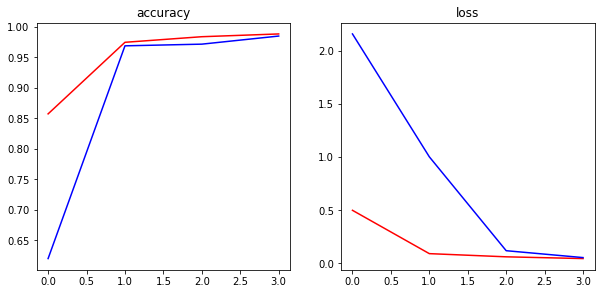

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(hist.history['accuracy'], color='r')
plt.plot(hist.history['val_accuracy'], color='b')
plt.title('accuracy')

#loss 조회
plt.subplot(2, 2, 2)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.title('loss')
plt.show()

#### layer확인

In [10]:

l1 = model.get_layer('block5_conv4')
l1.get_weights()
l1.get_weights()[0].shape #(5,5,1,16) -> kernel 16개 

(3, 3, 512, 512)

In [11]:
def plot_weight(w):
    w_min = np.min(w)
    w_max = np.max(w)
    
    num_grid = math.ceil(math.sqrt(w.shape[3]))
    fix, aixs = plt.subplots(num_grid, num_grid)
    
    for i, ax in enumerate(aixs.flat):
        if i < w.shape[3]:
            img = w[:,:,0,i]
            ax.imshow(img, vmin=w_min, vmax=w_max)
            
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
            
                        

#### CNN layer kernel확인

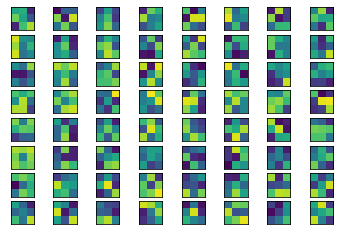

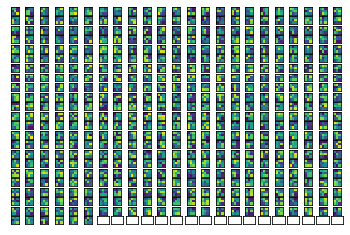

In [12]:
l1 = model.get_layer('block1_conv2')
w1 = l1.get_weights()[0]

plot_weight(w1)

l2 = model.get_layer('block5_conv4')
w2 = l2.get_weights()[0]

plot_weight(w2)

In [13]:
# 이런 conv2 첫번째 레이어를 통과한 결과 kernel 로 테스트 데이터를 predict하는 방법

temp_model = Model(inputs=model.get_layer('block1_conv1').input, outputs=model.get_layer('block1_conv2').output)
output = temp_model.predict(X_test)
output.shape


(10000, 28, 28, 64)

In [14]:
#(10000, 24, 24, 16) 두번째만 출력
def plot_temp_output(output):
        
    num_grid = math.ceil(math.sqrt(output.shape[3]))
    fix, aixs = plt.subplots(num_grid, num_grid)
    
    for i, ax in enumerate(aixs.flat):
        if i < output.shape[3]:
            img = output[0,:,:,i]
            ax.imshow(img, cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

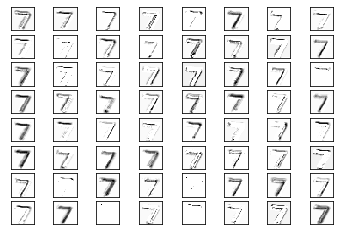

In [15]:
#첫번째 레이어의 출력 gradient영상예
plot_temp_output(output)